# Hotel Booking Cancellation Analysis

## Overview

This notebook aims to analyze the cancellation rates of hotel bookings based on various features.
The goal is to identify patterns and insights that can help in predicting cancellations and understanding customer behavior.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from statsmodels.stats.power import TTestIndPower
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import keras_tuner as kt
import optuna
from optuna.pruners import SuccessiveHalvingPruner
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level='INFO')
mlogger = logging.getLogger('matplotlib')
mlogger.setLevel(logging.WARNING)

## Dataset loading & main stats

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/sfnmro/python-ai-course/main/project/hotel_bookings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


## Feature Descriptions

- **hotel**: Type of hotel (Resort Hotel or City Hotel)
- **is_canceled**: Whether the booking was canceled (1) or not (0)
- **lead_time**: Number of days between the booking date and the arrival date
- **arrival_date_year**: Year of arrival date
- **arrival_date_month**: Month of arrival date
- **arrival_date_week_number**: Week number of arrival date
- **arrival_date_day_of_month**: Day of month of arrival date
- **stays_in_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **stays_in_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **adults**: Number of adults
- **children**: Number of children
- **babies**: Number of babies
- **meal**: Type of meal booked
- **country**: Country of origin
- **market_segment**: Market segment designation
- **distribution_channel**: Booking distribution channel
- **is_repeated_guest**: Whether the guest is a repeated guest (1) or not (0)
- **previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking
- **previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking
- **reserved_room_type**: Code of room type reserved
- **assigned_room_type**: Code for the type of room assigned to the booking
- **booking_changes**: Number of changes made to the booking
- **deposit_type**: Type of deposit made for the booking
- **agent**: ID of the travel agency that made the booking
- **company**: ID of the company/entity that made the booking
- **days_in_waiting_list**: Number of days the booking was in the waiting list before it was confirmed to the customer
- **customer_type**: Type of booking, assuming one of four categories
- **adr**: Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights
- **required_car_parking_spaces**: Number of car parking spaces required by the customer
- **total_of_special_requests**: Number of special requests made by the customer (e.g., twin bed or high floor)
- **reservation_status**: Reservation last status, assuming one of three values: Canceled, Check-Out, or No-Show
- **reservation_status_date**: Date at which the last status was set


## Logical analysis & feature removal

- **reservation_status**: This column directly indicates the result of the reservation, making it redundant for predictive modeling.

- **reservation_status_date**: The exact date of the reservation status change might not be relevant for prediction. Additionally, there is an issue where if this column is kept along with the arrival date, the model could infer cancellations if the `reservation_status_date` is before the arrival date. To prevent this leakage, this column will be removed.

- **arrival_date_year**: Predicting cancellations based on the year of arrival is unlikely to be meaningful, as it does not contribute significant predictive power.

- **arrival_date_week_number**: The week number is too granular and might not provide useful information for predicting cancellations.

- **arrival_date_day_of_month**: Similarly, the specific day of the month is too detailed and unlikely to add value to the predictive model.

In [5]:
columns_to_remove = [
    'arrival_date_year',
    'arrival_date_week_number',
    'arrival_date_day_of_month',
    'reservation_status',
    'reservation_status_date'
]

df = df.drop(columns=columns_to_remove)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_month              119390 non-null  object 
 4   stays_in_weekend_nights         119390 non-null  int64  
 5   stays_in_week_nights            119390 non-null  int64  
 6   adults                          119390 non-null  int64  
 7   children                        119386 non-null  float64
 8   babies                          119390 non-null  int64  
 9   meal                            119390 non-null  object 
 10  country                         118902 non-null  object 
 11  market_segment                  119390 non-null  object 
 12  distribution_cha

## Checking for Duplicates

To ensure the integrity of our dataset, we will check for any duplicate entries. Duplicate records can introduce bias and inaccuracies in our analysis and model predictions. Identifying and removing duplicates is a crucial step in data preprocessing.

In [7]:
duplicate_rows = df[df.duplicated()]
print("Duplicate rows: ", duplicate_rows.shape)

Duplicate rows:  (32442, 27)


In [8]:
"""
shape_before = df.shape
df = df.drop_duplicates()
shape_before, df.shape
"""

'\nshape_before = df.shape\ndf = df.drop_duplicates()\nshape_before, df.shape\n'

### From previous tries, removing duplicates removes a lot of rows and it impacts a lot accuracy of the model, so we will keep duplicates

## Checking for Missing Values

Next, we will check for missing values in our dataset. Missing data can affect the performance of our models and the reliability of our analysis. Identifying columns with missing values allows us to decide on appropriate strategies to handle them, such as imputation or removal.


In [9]:
missing_values = df.isnull().sum()
missing_values

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_month                     0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr             

## Visualizing Missing Values

For the columns with missing values: `children`, `country`, `agent`, and `company`, this visualization helps us understand the distribution of the data and the extent of the missing values in these columns. By identifying the most frequent categories, we can make informed decisions on how to handle the missing values in these columns.

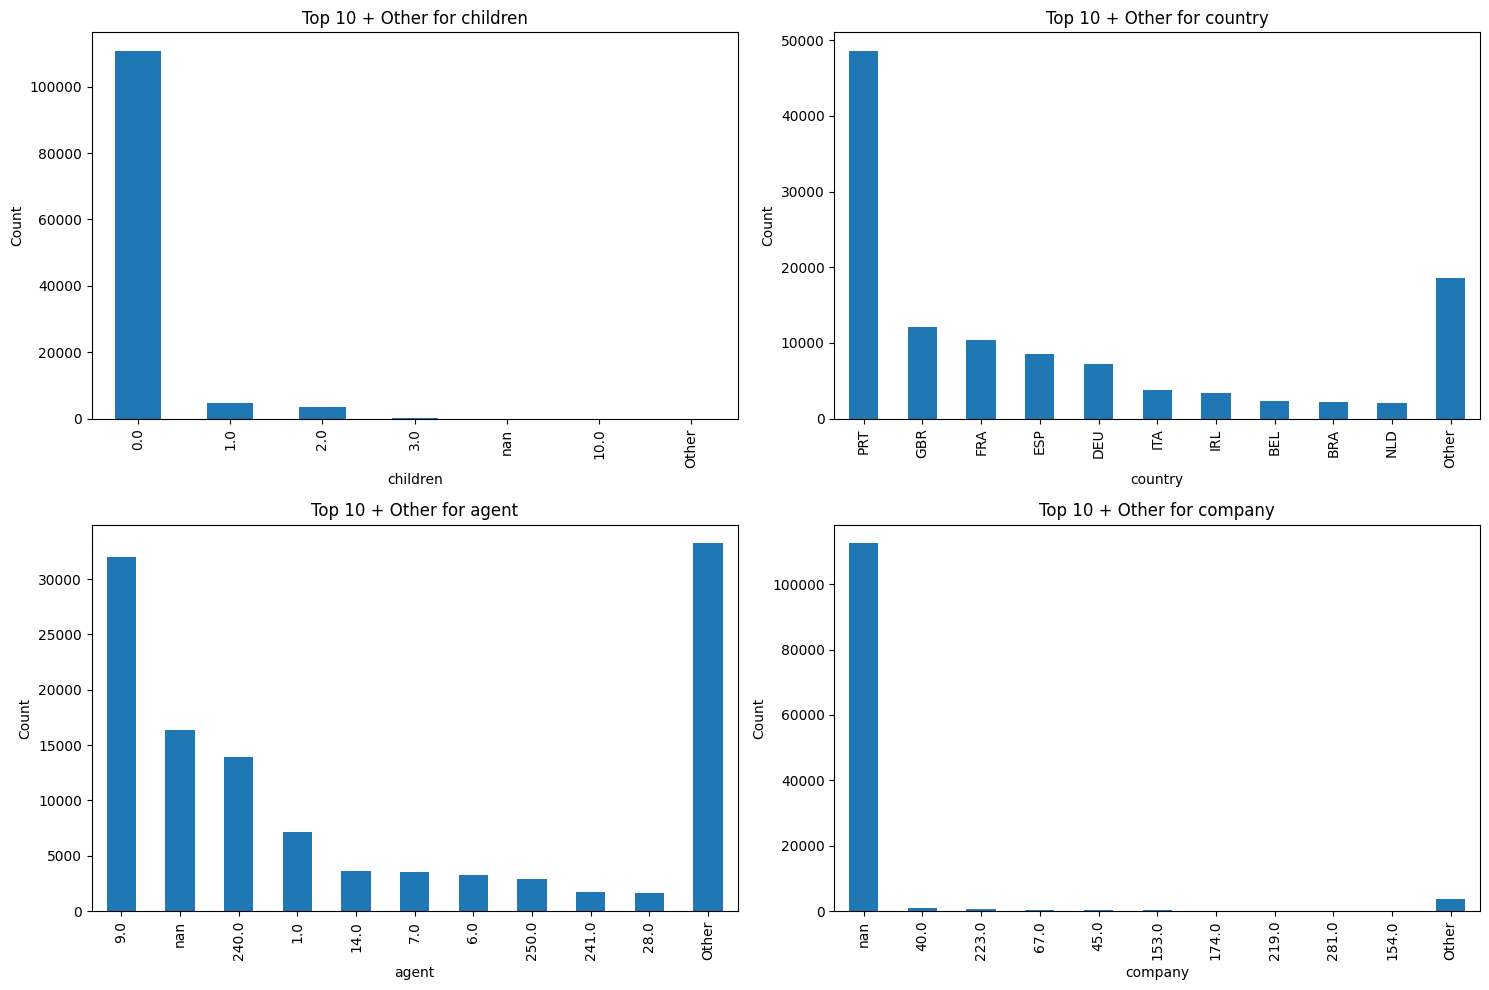

In [10]:
# List of columns to analyze
missing_cols = ['children', 'country', 'agent', 'company']

def get_value_counts(df, col):
    value_counts = df[col].value_counts(dropna=False).reset_index()
    value_counts.columns = [col, 'count']
    return value_counts

def prepare_top_values(value_counts, col, top_n=10):
    # Select the top N frequent values
    top_values = value_counts.head(top_n)

    # Sum the rest as 'Other'
    other_values = value_counts.iloc[top_n:]
    other_sum = other_values['count'].sum()

    # Append the 'Other' category
    top_values = pd.concat([top_values, pd.DataFrame({col: ['Other'], 'count': [other_sum]})], ignore_index=True) # Use concat instead of append

    return top_values

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through each column and generate the plots
for i, col in enumerate(missing_cols):
    value_counts = get_value_counts(df, col)
    top_values = prepare_top_values(value_counts, col)

    # Plot the value counts on the respective subplot
    top_values.plot(ax=axes[i], x=col, y='count', kind='bar', legend=False, title=f"Top 10 + Other for {col}")
    axes[i].set_ylabel('Count')

# Remove any empty subplots if missing_cols < 4
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Handling Missing Values

To address the missing values in our dataset, we will apply the following strategies:

- **`children`**: Replace missing values with the median. The median is a robust measure that is less affected by outliers and represents the central tendency of the data.
- **`country`**: Replace missing values with the mode. The mode represents the most frequent category, ensuring that the imputed values are plausible and representative of the dataset.
- **`agent`**: Replace missing values with 'No Agent'. This category indicates bookings made without an agent, providing a meaningful imputation for the missing data.
- **`company`**: Drop the `company` column. This column has a high proportion of missing values, making it difficult to impute without introducing significant bias. Dropping this column helps maintain data quality and integrity.

After applying these strategies, we will verify if there are any remaining missing values in the dataset to ensure completeness.


In [11]:
# Replace missing values in 'children' with the median
df['children'].fillna(df['children'].median(), inplace=True)

# Replace missing values in 'country' with the mode
df['country'].fillna(df['country'].mode()[0], inplace=True)

# Replace missing values in 'agent' with No Agent
df['agent'].fillna('No Agent', inplace=True)

# Drop the 'company' column as it has too many missing values
df = df.drop(columns=['company'])

# Verify if there are any remaining missing values
missing_values_after = df.isnull().sum()
missing_values_after

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

## Numerical and Categorical Feature Analysis

In this section, we will analyze both numerical and categorical features to understand their distribution and relationship with the target variable.

- **Numerical Features**: We will examine the distribution, central tendency, and dispersion of numerical features. This analysis helps identify any skewness, outliers, or patterns that may influence the target variable.

- **Categorical Features**: We will explore the frequency distribution and cancellation rates within each category. This analysis provides insights into how different categories relate to booking cancellations and can highlight important patterns or trends.

By analyzing these features, we aim to uncover valuable information that will guide our feature engineering and model building processes.

In [12]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns

numerical_columns, categorical_columns

(Index(['is_canceled', 'lead_time', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies',
        'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'booking_changes',
        'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
        'total_of_special_requests'],
       dtype='object'),
 Index(['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment',
        'distribution_channel', 'reserved_room_type', 'assigned_room_type',
        'deposit_type', 'agent', 'customer_type'],
       dtype='object'))

In [13]:
df_num = df[numerical_columns]
df_num.head()

,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,0,342,0,0,2,0.0,0,0,0,0,3,0,0.0,0,0
1,0,737,0,0,2,0.0,0,0,0,0,4,0,0.0,0,0
2,0,7,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0
3,0,13,0,1,1,0.0,0,0,0,0,0,0,75.0,0,0
4,0,14,0,2,2,0.0,0,0,0,0,0,0,98.0,0,1


In [14]:
df_cat = df[categorical_columns]
df_cat.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,agent,customer_type
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,No Agent,Transient
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,C,No Deposit,No Agent,Transient
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,C,No Deposit,No Agent,Transient
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,304.0,Transient
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,240.0,Transient


## Numerical Features

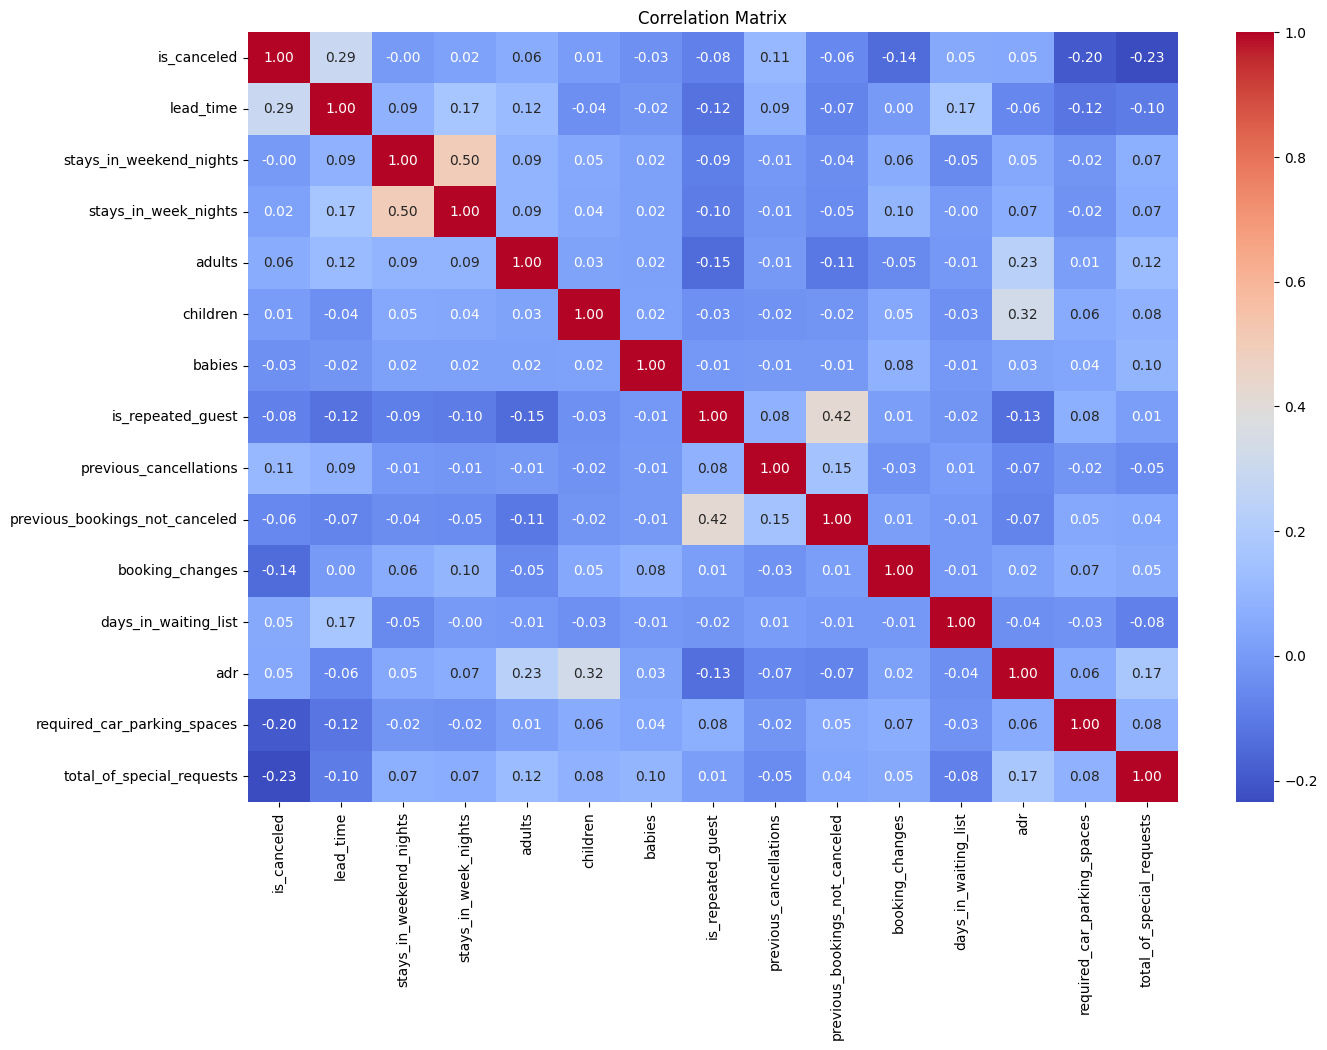

In [15]:
correlation_matrix = df_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [16]:
correlation_with_target = correlation_matrix["is_canceled"].sort_values(ascending=False)
correlation_with_target

is_canceled                       1.000000
lead_time                         0.293123
previous_cancellations            0.110133
adults                            0.060017
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
children                          0.005036
stays_in_weekend_nights          -0.001791
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
is_repeated_guest                -0.084793
booking_changes                  -0.144381
required_car_parking_spaces      -0.195498
total_of_special_requests        -0.234658
Name: is_canceled, dtype: float64

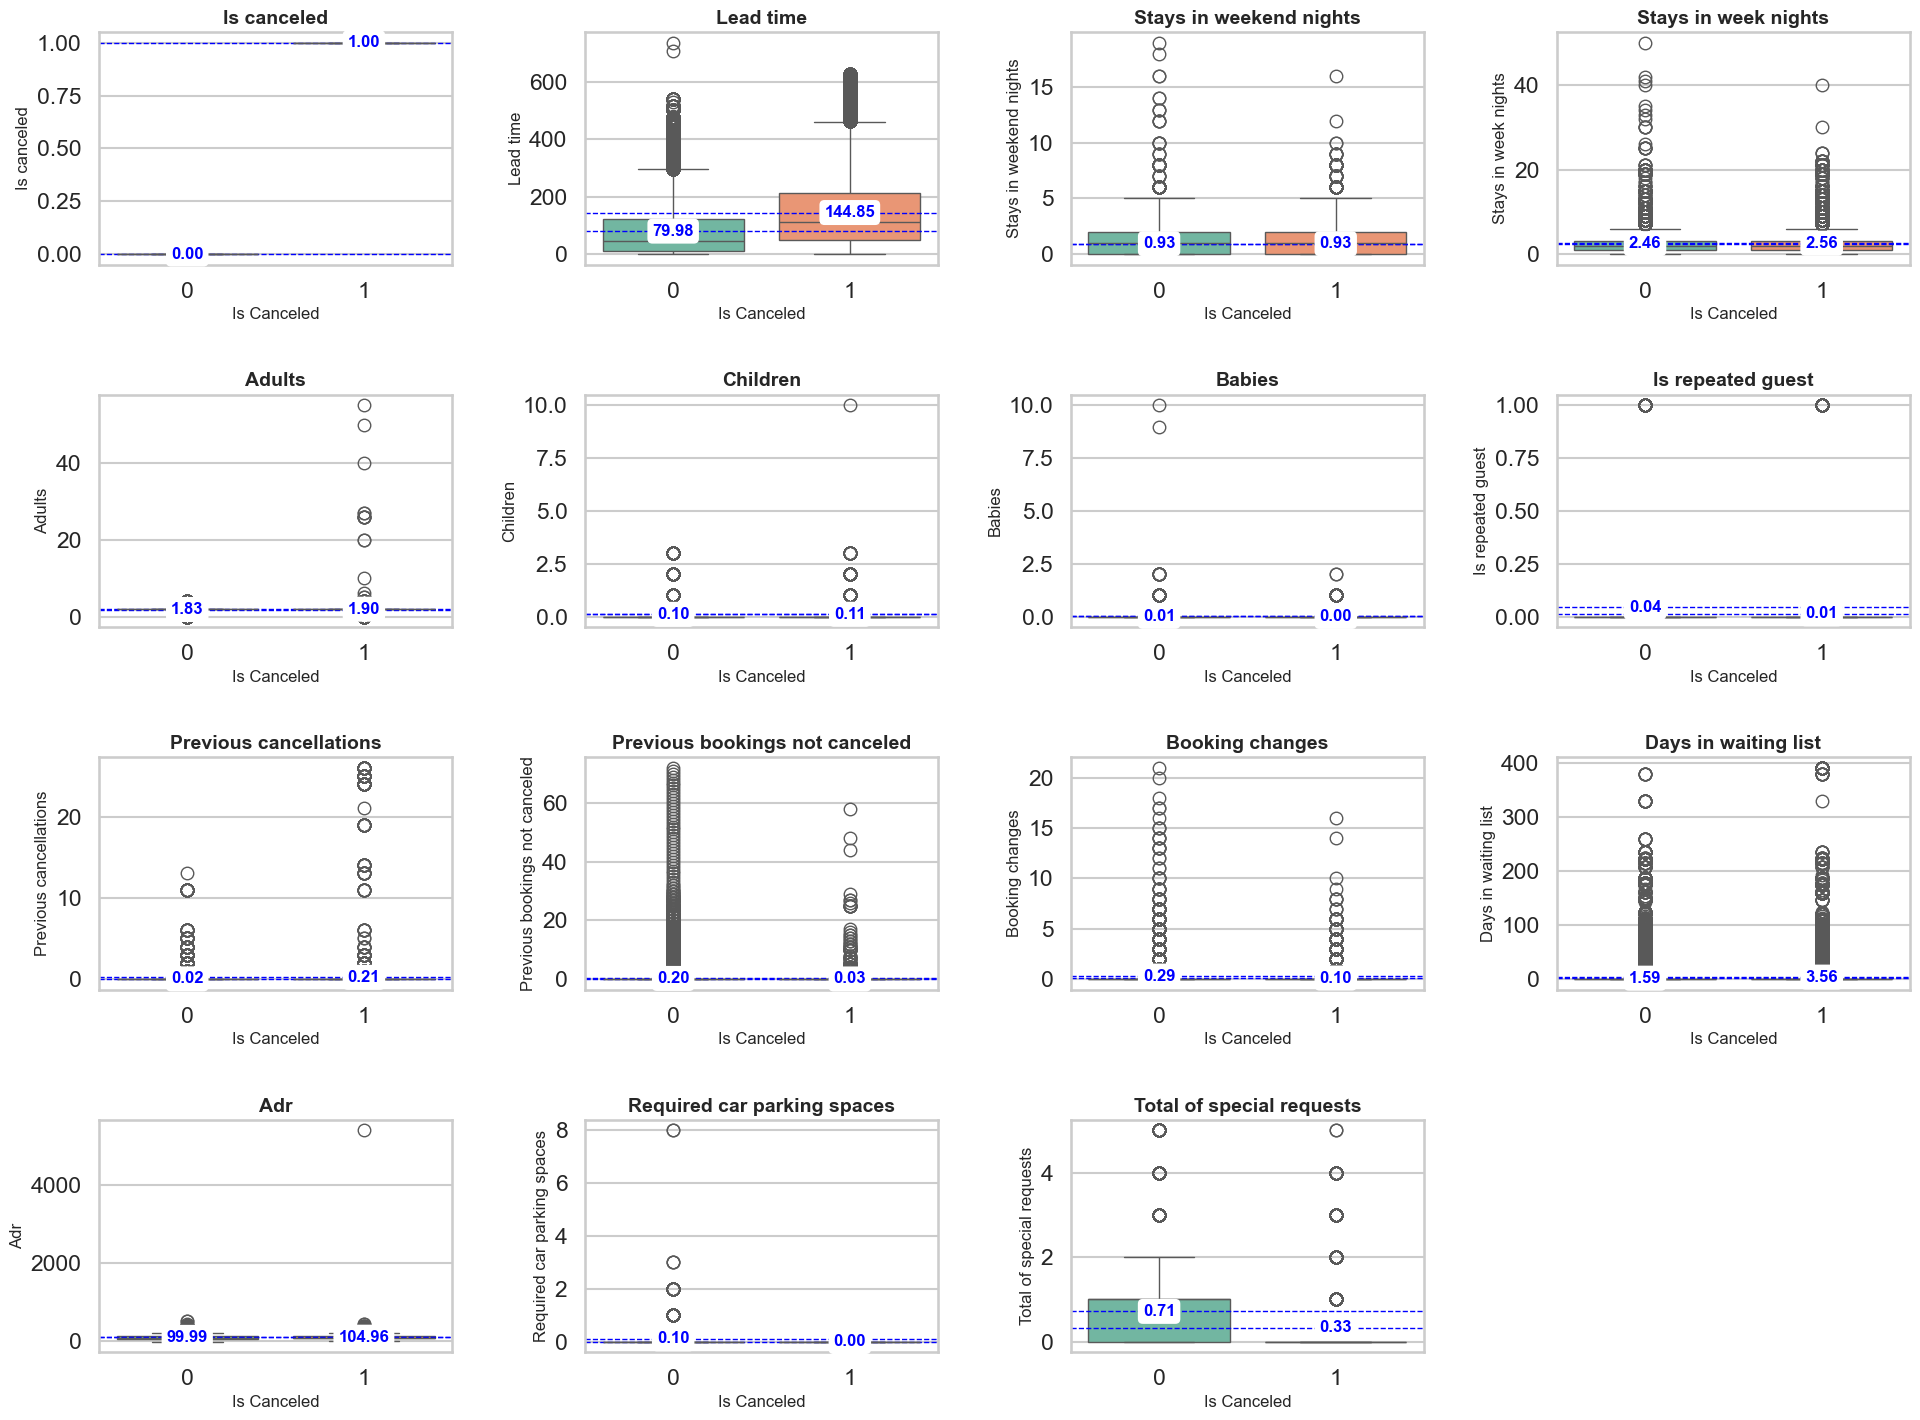

In [17]:
palette = sns.color_palette("Set2")

# Function to plot feature distribution with mean annotations
def plot_feature_distribution(df, feature, ax, palette):
    sns.boxplot(x='is_canceled', y=feature, data=df, ax=ax, palette=palette)
    ax.set_title(feature.capitalize().replace('_', ' '), fontsize=14, fontweight='bold')
    ax.set_xlabel('Is Canceled', fontsize=12)
    ax.set_ylabel(feature.capitalize().replace('_', ' '), fontsize=12)
    ax.yaxis.grid(True)

    # Add horizontal lines and text for mean values
    means = df.groupby('is_canceled')[feature].mean()
    for tick, mean in zip(ax.get_xticks(), means):
        ax.axhline(mean, color='blue', linestyle='--', linewidth=1)
        ax.text(tick, mean, f'{mean:.2f}', horizontalalignment='center', color='blue', weight='semibold', fontsize=12, va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Set up the matplotlib figure for all numerical features
sns.set_style("whitegrid")
sns.set_context("talk")

# Create a figure with subplots
fig, axes = plt.subplots(nrows=(len(df_num.columns) // 4) + 1, ncols=4, figsize=(20, 15))

# Plotting the distribution of numerical features, grouped by the target variable 'is_canceled' with Boxplot
for idx, feat in enumerate(df_num.columns):
    ax = axes[int(idx / 4), idx % 4]
    plot_feature_distribution(df_num, feat, ax, palette)

# Remove any unused subplots
for idx in range(len(df_num.columns), len(axes.flatten())):
    fig.delaxes(axes.flatten()[idx])

# Adjust the layout
fig.tight_layout(pad=2.0)
plt.show()

From the visualizations above, we can draw several key insights regarding the numerical features and their relationship with the cancellation status (`is_canceled`):

1. **Lead Time**: Bookings with longer lead times are more likely to be canceled. The median lead time for canceled bookings is significantly higher than for non-canceled bookings.

2. **Stays in Weekend Nights and Week Nights**: There is no significant difference in the number of weekend or weeknight stays between canceled and non-canceled bookings.

3. **Adults, Children, and Babies**: The number of adults, children, and babies shows minimal difference between canceled and non-canceled bookings.

4. **Is Repeated Guest**: Non-repeated guests have a higher cancellation rate compared to repeated guests.

5. **Previous Cancellations and Previous Bookings Not Canceled**: Bookings with previous cancellations are more likely to be canceled again. Conversely, bookings with previous successful (not canceled) bookings are less likely to be canceled.

6. **Booking Changes**: Bookings with more changes tend to have higher cancellation rates.

7. **Days in Waiting List**: Bookings that spent more days on the waiting list are more likely to be canceled.

8. **ADR (Average Daily Rate)**: Higher ADR values are associated with a higher likelihood of cancellation.

9. **Required Car Parking Spaces**: This feature does not show a clear pattern with cancellation rates.

10. **Total of Special Requests**: Bookings with more special requests tend to have lower cancellation rates.

### Next Steps

To enhance our dataset and prepare it for modeling, we will perform the following transformations and feature engineering steps:

1. **Create a `guests` Column**: Combine the number of adults, children, and babies into a single column representing the total number of guests.
2. **Create a `has_children` Column**: Create a binary column indicating whether a booking includes children (1) or not (0).
3. **Create a `total_stay_nights` Column**: Sum the `stays_in_week_nights` and `stays_in_weekend_nights` columns to represent the total number of nights stayed.

These transformations will help consolidate information and potentially reveal more meaningful patterns in the data.


In [18]:
df['guests'] = df['adults'] + df['children'] + df['babies']
df['has_children'] = (df['children'] > 0).astype(int)
df['total_stay_nights'] = df['stays_in_week_nights'] + df['stays_in_weekend_nights']
df = df.drop(columns=['adults', 'children', 'babies','stays_in_week_nights', 'stays_in_weekend_nights'])

In [19]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
numerical_columns

df_num = df[numerical_columns]
df_num.head()

,is_canceled,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,guests,has_children,total_stay_nights
0,0,342,0,0,0,3,0,0.0,0,0,2.0,0,0
1,0,737,0,0,0,4,0,0.0,0,0,2.0,0,0
2,0,7,0,0,0,0,0,75.0,0,0,1.0,0,1
3,0,13,0,0,0,0,0,75.0,0,0,1.0,0,1
4,0,14,0,0,0,0,0,98.0,0,1,2.0,0,2


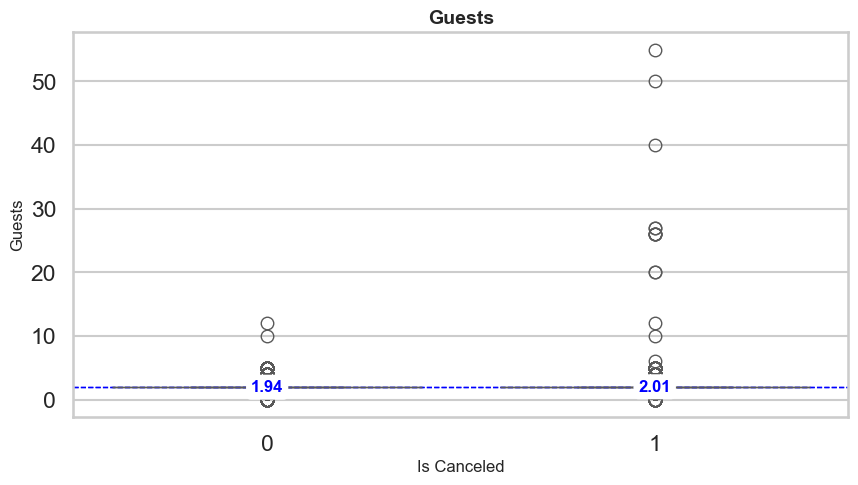

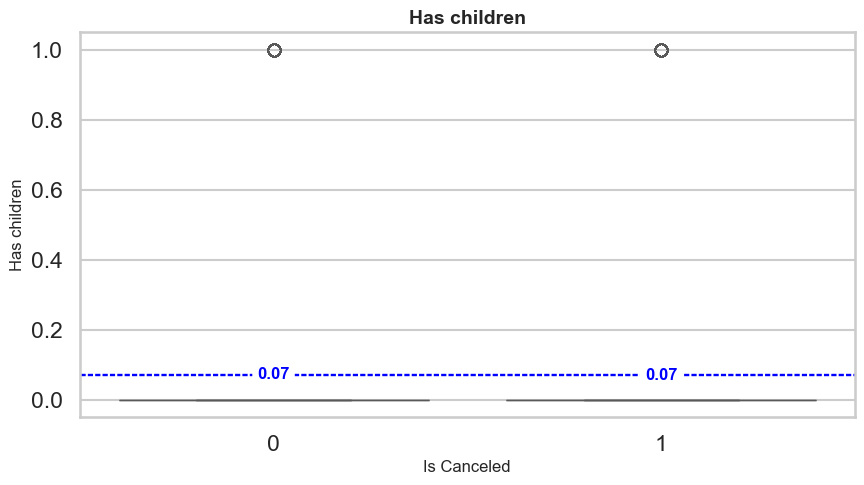

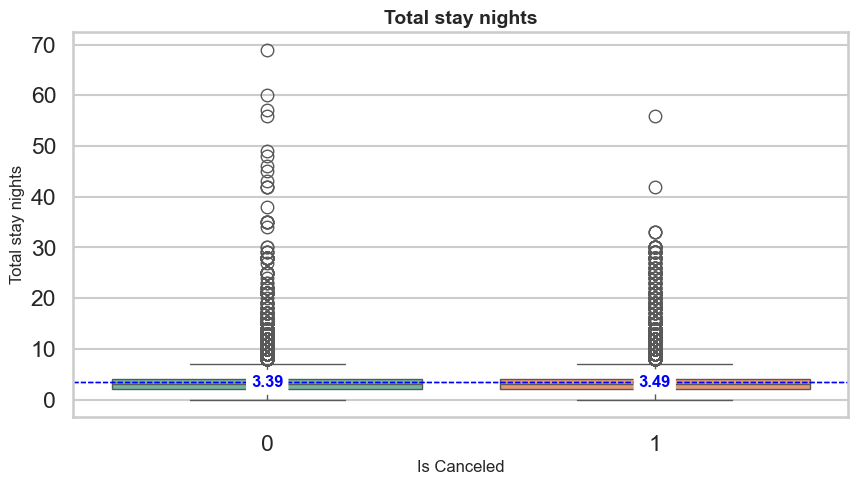

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_feature_distribution(df_num, 'guests', ax, palette)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
plot_feature_distribution(df_num, 'has_children', ax, palette)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
plot_feature_distribution(df_num, 'total_stay_nights', ax, palette)
plt.show()

### Analysis of the New Features: `has_children`, `guests`, and `total_stay_nights`

#### Has Children
1. **Uniform Distribution**: The proportion of bookings with children is very low and almost identical between canceled and non-canceled bookings. Both have approximately 7% of bookings with children.
2. **Impact on Cancellations**: Given the nearly identical proportions, the presence of children does not appear to significantly influence the cancellation rate.

#### Guests
1. **Slight Difference in Means**: The average number of guests is slightly higher for canceled bookings (2.01) compared to non-canceled bookings (1.94). This difference is minimal but noticeable.
2. **Wide Range of Values**: Both canceled and non-canceled bookings have a wide range of guest counts, with some extreme values.

####  Total Stay Nights
1. **Slight Difference in Means**: The average total stay nights is slightly higher for canceled bookings (3.49) compared to non-canceled bookings (3.39). Similar to the `guests` feature, this difference is minimal but present.
2. **Wide Range of Values**: Both canceled and non-canceled bookings exhibit a wide range of total stay nights, with some extreme values.

####  Next steps
Despite the lack of strong relationships between these new features and cancellations, we will retain the `has_children`, `guests`, and `total_stay_nights` columns for completeness. It is possible that, in combination with other features, these columns may still contribute valuable information to the predictive model.


### Distribution and Outliers

The visualizations above provide a comprehensive view of the distributions and the presence of outliers in the numerical features of our dataset.

#### Objectives:

1. **Understand Distribution**: Examine the histograms and Q-Q plots to understand the distribution of each numerical feature. This helps in identifying whether the data follows a normal distribution or if there is skewness that needs to be addressed.
   
2. **Detect Outliers**: Utilize box plots to identify the presence and extent of outliers in the data. Outliers can significantly impact the performance of machine learning models and may need to be handled appropriately.

#### Next Steps:

- **Transformation Consideration**: Based on the distribution analysis, decide if numerical features require transformations (e.g., log transformation) to normalize the data and improve model performance.
- **Outlier Handling**: Analyze the outliers detected in the box plots to determine whether they should be removed, capped, or if robust models should be employed to handle them effectively.

By gathering detailed information from these visualizations, we aim to make informed decisions on how to preprocess and transform the numerical features for optimal modeling outcomes.


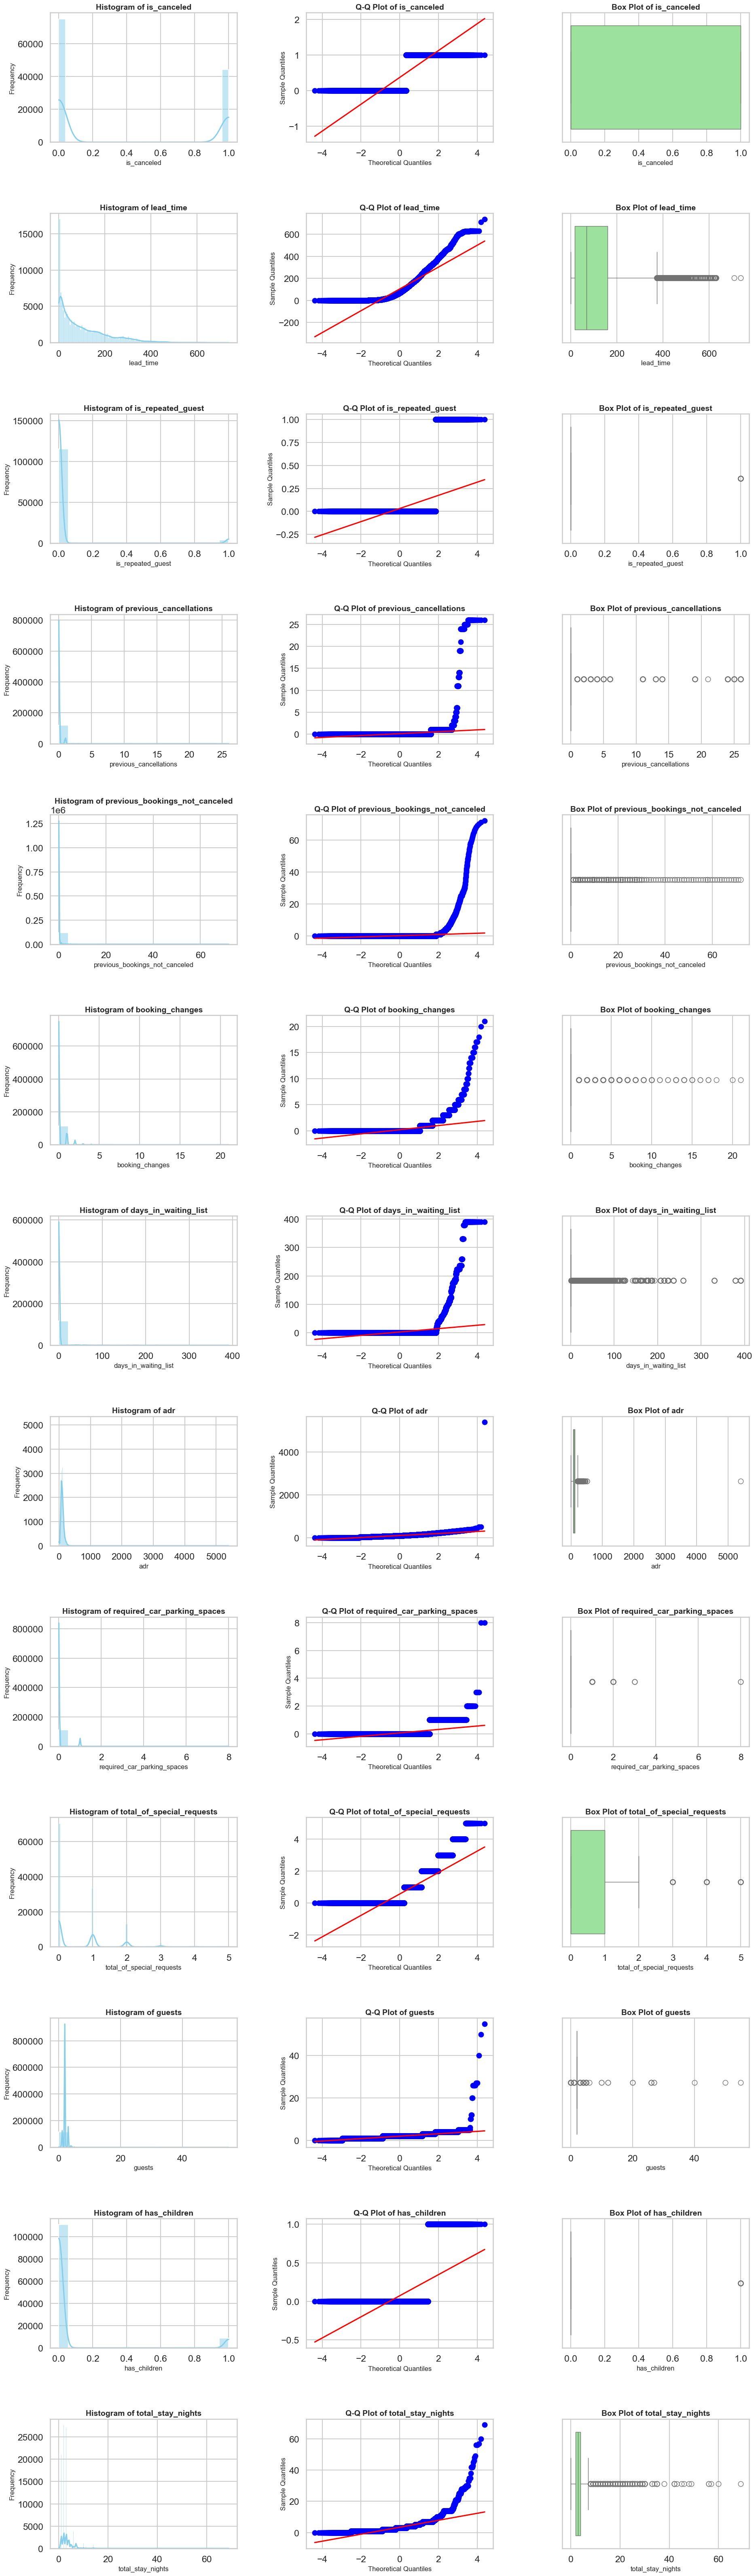

In [21]:
# Function to create histograms, Q-Q plots, and box plots
def num_transformation_analysis(data, columns):
    fig, axes = plt.subplots(nrows=len(columns), ncols=3, figsize=(20, len(columns) * 5))

    for idx, col in enumerate(columns):
        # Histogram
        sns.histplot(data[col], kde=True, ax=axes[idx, 0], color='skyblue')
        axes[idx, 0].set_title(f'Histogram of {col}', fontsize=14, fontweight='bold')
        axes[idx, 0].set_xlabel(col, fontsize=12)
        axes[idx, 0].set_ylabel('Frequency', fontsize=12)

        # Q-Q Plot
        stats.probplot(data[col].dropna(), dist="norm", plot=axes[idx, 1])
        axes[idx, 1].set_title(f'Q-Q Plot of {col}', fontsize=14, fontweight='bold')
        axes[idx, 1].set_xlabel('Theoretical Quantiles', fontsize=12)
        axes[idx, 1].set_ylabel('Sample Quantiles', fontsize=12)

        # Box Plot
        sns.boxplot(x=data[col], ax=axes[idx, 2], color='lightgreen')
        axes[idx, 2].set_title(f'Box Plot of {col}', fontsize=14, fontweight='bold')
        axes[idx, 2].set_xlabel(col, fontsize=12)

    fig.tight_layout(pad=3.0)
    plt.show()

# Plot distributions for numerical columns
num_transformation_analysis(df_num, numerical_columns)

In [22]:
def calculate_outlier_metrics(data, columns):
    summary_stats = data[columns].describe().T
    summary_stats['IQR'] = summary_stats['75%'] - summary_stats['25%']
    summary_stats['Lower Bound'] = summary_stats['25%'] - 1.5 * summary_stats['IQR']
    summary_stats['Upper Bound'] = summary_stats['75%'] + 1.5 * summary_stats['IQR']

    for col in columns:
        lower_bound = summary_stats.at[col, 'Lower Bound']
        upper_bound = summary_stats.at[col, 'Upper Bound']
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        summary_stats.at[col, 'Outliers'] = len(outliers)
        summary_stats.at[col, 'Outlier Percentage'] = 100 * len(outliers) / len(data)

    return summary_stats

calculate_outlier_metrics(df_num, numerical_columns)

,count,mean,std,min,25%,50%,75%,max,IQR,Lower Bound,Upper Bound,Outliers,Outlier Percentage
is_canceled,119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0,1.00,-1.500,2.500,0.0,0.000000
lead_time,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0,142.00,-195.000,373.000,3005.0,2.516961
is_repeated_guest,119390.0,0.031912,0.175767,0.00,0.00,0.000,0.0,1.0,0.00,0.000,0.000,3810.0,3.191222
previous_cancellations,119390.0,0.087118,0.844336,0.00,0.00,0.000,0.0,26.0,0.00,0.000,0.000,6484.0,5.430941
previous_bookings_not_canceled,119390.0,0.137097,1.497437,0.00,0.00,0.000,0.0,72.0,0.00,0.000,0.000,3620.0,3.032080
booking_changes,119390.0,0.221124,0.652306,0.00,0.00,0.000,0.0,21.0,0.00,0.000,0.000,18076.0,15.140297
days_in_waiting_list,119390.0,2.321149,17.594721,0.00,0.00,0.000,0.0,391.0,0.00,0.000,0.000,3698.0,3.097412
adr,119390.0,101.831122,50.535790,-6.38,69.29,94.575,126.0,5400.0,56.71,-15.775,211.065,3793.0,3.176983
required_car_parking_spaces,119390.0,0.062518,0.245291,0.00,0.00,0.000,0.0,8.0,0.00,0.000,0.000,7416.0,6.211576
total_of_special_requests,119390.0,0.571363,0.792798,0.00,0.00,0.000,1.0,5.0,1.00,-1.500,2.500,2877.0,2.409750


### Transformation Decisions

Based on the distribution and outlier analysis, the following transformations will be applied to the numerical features:

- **is_canceled**:
  - **Transformation**: None needed.
  - **Reason**: This is a binary variable (0 or 1) representing cancellations.

- **lead_time**:
  - **Transformation**: Log transformation.
  - **Reason**: The distribution is highly skewed with significant outliers. Applying a log transformation can reduce skewness and stabilize variance.

- **is_repeated_guest**:
  - **Transformation**: None needed.
  - **Reason**: This is a binary variable (0 or 1) indicating repeated guests.

- **previous_cancellations**:
  - **Transformation**: Log transformation.
  - **Reason**: The distribution has many zeros and a long tail. A log transformation (log(x+1)) can help in normalizing the distribution.

- **previous_bookings_not_canceled**:
  - **Transformation**: Log transformation.
  - **Reason**: Similar to previous cancellations, this variable has a skewed distribution with a long tail. Log transformation (log(x+1)) can help.

- **booking_changes**:
  - **Transformation**: None needed.
  - **Reason**: The variable has a skewed distribution, but the values are relatively small and can be handled by robust models.

- **days_in_waiting_list**:
  - **Transformation**: Log transformation.
  - **Reason**: This variable has a skewed distribution with a significant number of outliers. Log transformation (log(x+1)) can help in normalizing it.

- **adr (Average Daily Rate)**:
  - **Transformation**: Log transformation.
  - **Reason**: The distribution is highly skewed with many extreme values. Log transformation can stabilize variance and reduce skewness.

- **required_car_parking_spaces**:
  - **Transformation**: None needed.
  - **Reason**: Although it has a few outliers, the values are mostly discrete and small, which can be handled by robust models.

- **total_of_special_requests**:
  - **Transformation**: None needed.
  - **Reason**: This variable has a small range of discrete values, which is suitable for most models without transformation.

- **guests**:
  - **Transformation**: None needed.
  - **Reason**: Although it has some extreme values, retaining the original values will preserve important information about guest count.

- **has_children**:
  - **Transformation**: None needed.
  - **Reason**: This is a binary variable (0 or 1) indicating whether the guest has children.

- **total_stay_nights**:
  - **Transformation**: Log transformation.
  - **Reason**: The distribution is highly skewed with many extreme values. Log transformation can reduce skewness and make the distribution more normal.

### Standard Scaling

After applying the above transformations, I will also standard scale the features that underwent log transformation. Standard scaling will ensure that these features have a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms to perform optimally.

The features that will be standard scaled are:
- lead_time
- previous_cancellations
- previous_bookings_not_canceled
- days_in_waiting_list
- adr (Average Daily Rate)
- total_stay_nights

### Reason for Not Scaling Other Features

The binary features (`is_canceled`, `is_repeated_guest`, `has_children`) and discrete features (`required_car_parking_spaces`, `total_of_special_requests`, `guests`) do not require standard scaling:
- **Binary Features**: These are already in a standard format (0 or 1) and do not benefit from standard scaling.
- **Discrete Features**: These features have small ranges and are less impacted by differences in scale.

### Outlier Handling

- **Guests and Booking Changes**: These features have a significant number of outliers. Removing these outliers would result in a substantial loss of data. Therefore, outliers will be retained to preserve the integrity and richness of the dataset.

### Previous Attempts

- **Capping Outliers**: Previous attempts to cap outliers at a maximum value resulted in lower model accuracies. Hence, the decision was made to keep all data points, including outliers.

### Conclusion

The log transformations and subsequent standard scaling will help normalize the distributions of the skewed features, improving the performance and stability of the predictive models. Retaining all outliers ensures that valuable information is not lost during preprocessing.


In [23]:
df_before_log = df.copy()
# Log transformation for skewed features
log_transformed_features = [
    'previous_cancellations', 'lead_time', 'previous_bookings_not_canceled',
    'days_in_waiting_list', 'adr', 'total_stay_nights'
]
# Apply log1p transformation (log(1 + x) to handle zero values)
for feature in log_transformed_features:
    df[feature] = np.log1p(df[feature])

# Standard scaling for all numerical features (if needed)
scaler = StandardScaler()
df[log_transformed_features] = scaler.fit_transform(df[log_transformed_features])
df_num = df[numerical_columns]

#print the variance of the numerical columns
df_num.var()


is_canceled                       0.233210
lead_time                         1.000008
is_repeated_guest                 0.030894
previous_cancellations            1.000008
previous_bookings_not_canceled    1.000008
booking_changes                   0.425503
days_in_waiting_list              1.000008
adr                               1.000008
required_car_parking_spaces       0.060168
total_of_special_requests         0.628529
guests                            0.521853
has_children                      0.066773
total_stay_nights                 1.000008
dtype: float64

In [24]:
#check if we have NaN values in the numerical columns
df_num.isnull().sum()

is_canceled                       0
lead_time                         0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               1
required_car_parking_spaces       0
total_of_special_requests         0
guests                            0
has_children                      0
total_stay_nights                 0
dtype: int64

#### We ended up creating a NaN value in adr - this means we had a negative value, which it was prolly an input mistake. We will fill it with the mean.

In [25]:
#fix adr column
df['adr'] = df['adr'].fillna(df['adr'].mean())
df_num = df[numerical_columns]
df_num.isnull().sum()

is_canceled                       0
lead_time                         0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
booking_changes                   0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
guests                            0
has_children                      0
total_stay_nights                 0
dtype: int64

## Categorical Features

The visualizations below display the distribution of various categorical features in relation to the cancellation status (`is_canceled`).

### Objectives:

1. **Assess Informativeness**: Determine whether each categorical feature provides useful information that can help predict cancellations.
2. **Identify Necessary Actions**: Evaluate if any preprocessing steps, such as grouping rare categories or encoding, are required to enhance the feature's contribution to the predictive model.

By analyzing these categorical features, we aim to identify key patterns and insights that will inform our data preprocessing and feature engineering strategies.

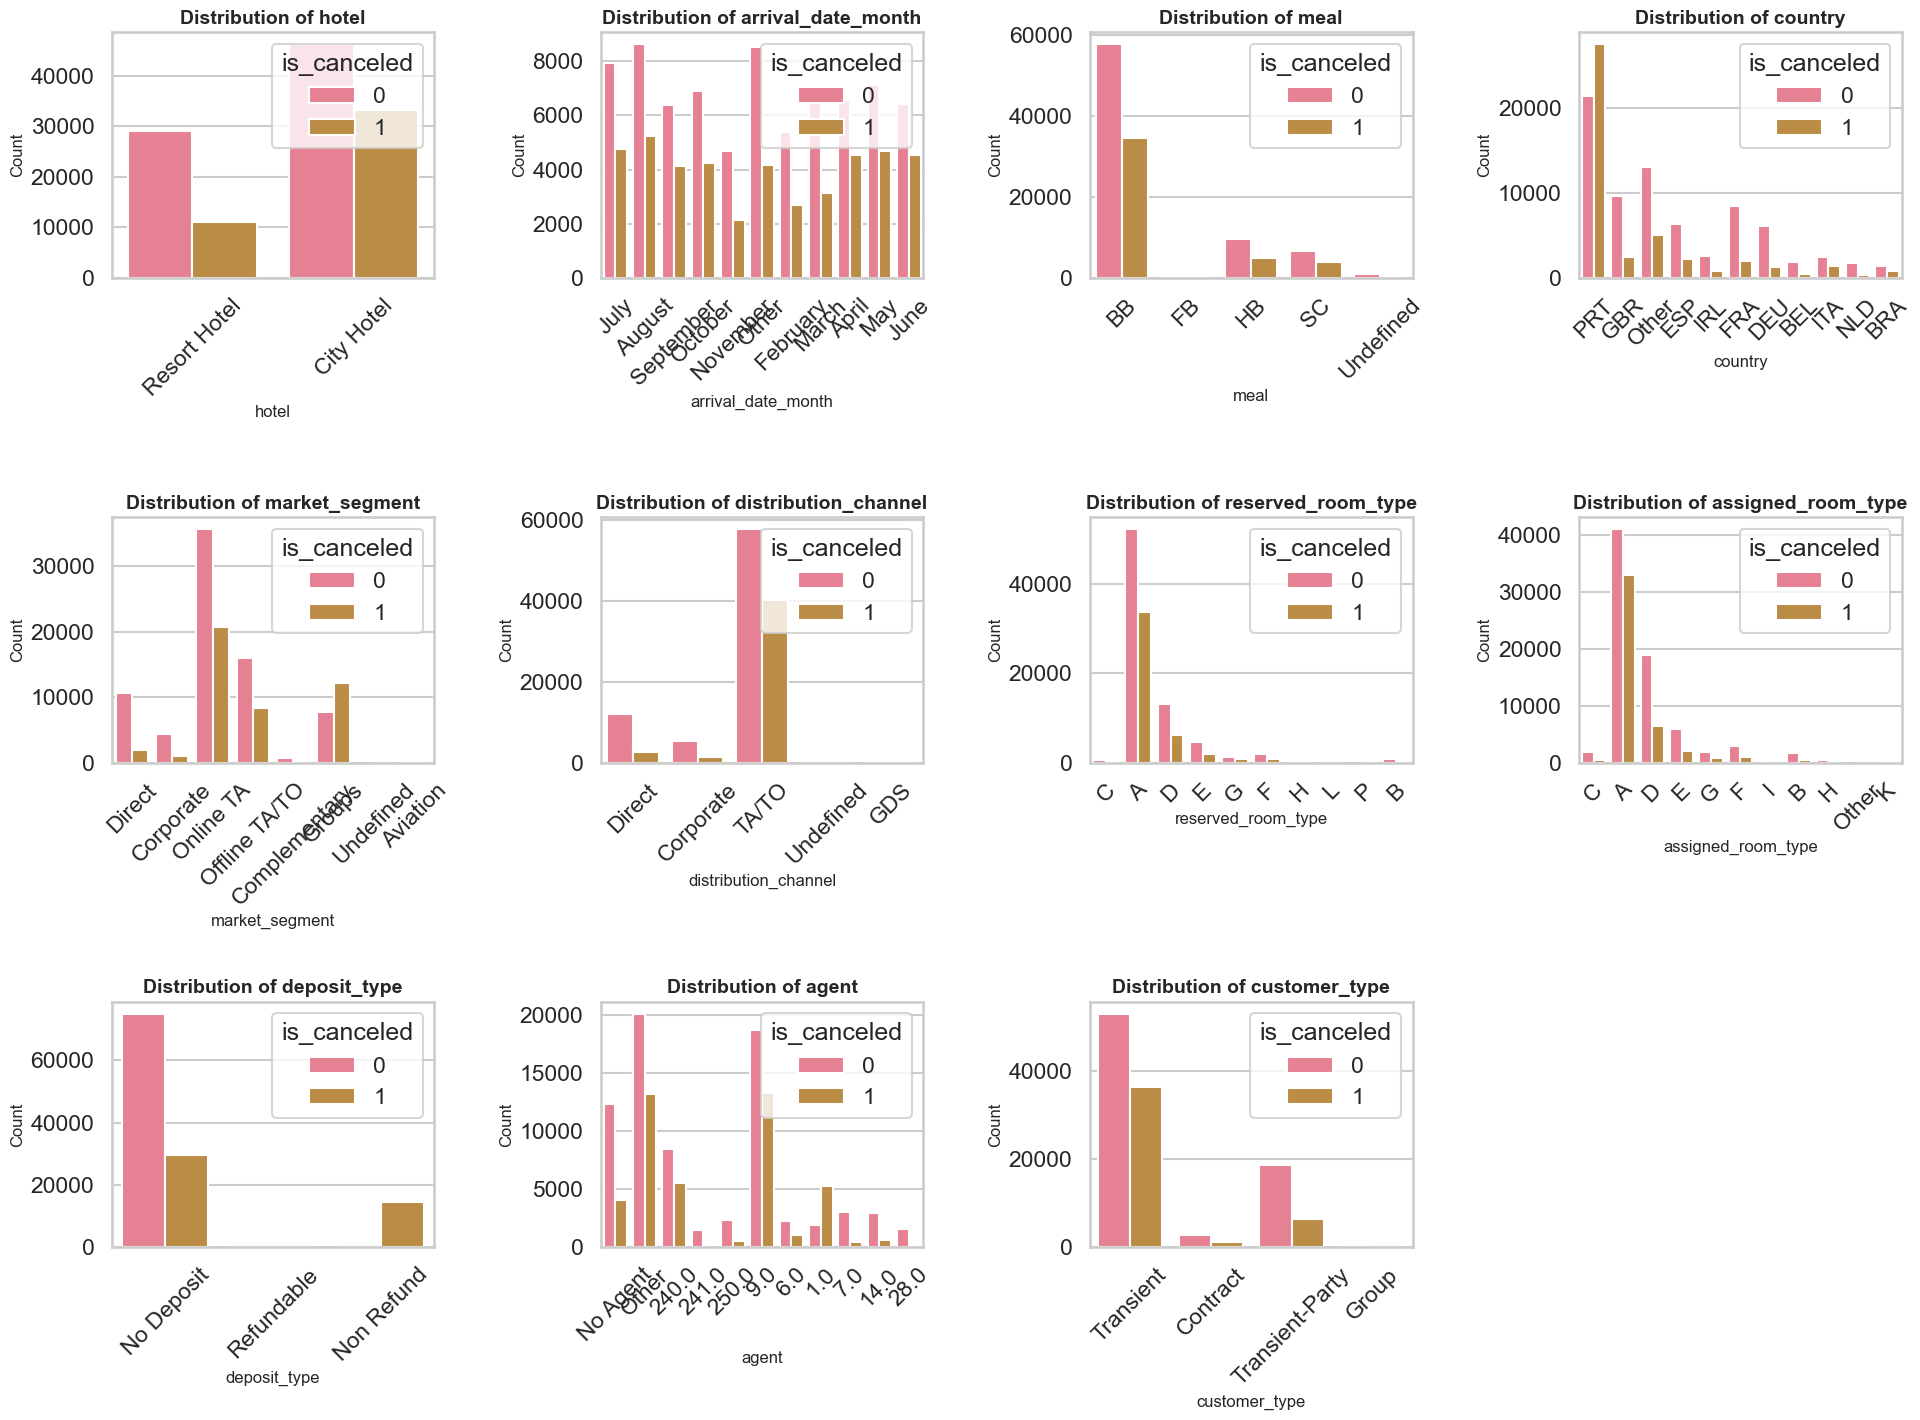

In [26]:
# Function to group less frequent categories into 'Other'
def group_others(df, col, top_n=5):
    top_values = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].apply(lambda x: x if x in top_values else 'Other')
    return df

# Function to plot the distribution of a categorical feature
def plot_categorical_feature(df, feature, ax, palette, hue='is_canceled', top_n=10):
    cloned_df = df.copy()
    if cloned_df[feature].nunique() > top_n:
        cloned_df = group_others(cloned_df, feature, top_n)
    sns.countplot(x=feature, hue=hue, data=cloned_df, ax=ax, palette=palette)
    ax.set_title(f'Distribution of {feature}', fontsize=14, fontweight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.legend(title=hue, loc='upper right')
    ax.tick_params(axis='x', rotation=45)

# List of categorical features to visualize
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

# Custom color palette for better visual distinction
palette = sns.color_palette("husl", 8)

# Plotting the distribution of categorical features
for i, feature in enumerate(categorical_columns):
    row, col = divmod(i, 4)
    plot_categorical_feature(df, feature, axes[row, col], palette)

# Remove any empty subplot
if len(categorical_columns) < 12:
    for idx in range(len(categorical_columns), 12):
        fig.delaxes(axes.flatten()[idx])

plt.tight_layout(pad=2.0)
plt.show()


## Conclusions and Next Steps for Categorical Features

### Hotel
- **Conclusion**: There is a clear distinction between the cancellation rates for Resort Hotel and City Hotel. This column is informative.
- **Action**: Retain as is.

### Arrival Date Month
- **Conclusion**: Shows distinct patterns in cancellations across different months. This is useful information.
- **Action**: Consider creating a cyclical feature to capture the seasonal nature of the data (e.g., using sine and cosine transformations).

### Meal
- **Conclusion**: Different meal types show varied cancellation rates. This column provides insights.
- **Action**: Retain as is.

### Country
- **Conclusion**: Most of the data points are concentrated in a few countries, with a significant portion in "Other". This column may introduce a lot of noise due to high cardinality.
- **Action**: Group less frequent countries into "Other" and consider one-hot encoding for the most frequent countries.

### Market Segment
- **Conclusion**: Shows significant differences in cancellation rates across segments. This column is informative.
- **Action**: Retain as is.

### Distribution Channel
- **Conclusion**: Similar to market segment, this column shows clear differences. It is useful.
- **Action**: Retain as is.

### Reserved Room Type
- **Conclusion**: Provides clear insights into different room types and their cancellation rates. This column is informative.
- **Action**: Retain as is.

### Assigned Room Type
- **Conclusion**: Shows patterns similar to reserved room type, but may have overlapping information.
- **Action**: Evaluate the correlation between Reserved Room Type and Assigned Room Type. If highly correlated, consider dropping one or creating a new feature that captures discrepancies between the two (e.g., whether the assigned room type matches the reserved room type).

### Deposit Type
- **Conclusion**: Significant differences in cancellation rates based on deposit type. This column is informative.
- **Action**: Retain as is.

### Agent
- **Conclusion**: There are many unique agents, but a few dominant ones. This could be useful but may need encoding or grouping.
- **Action**: Group less frequent agents into an "Other" category and consider one-hot encoding or target encoding for the most frequent agents.

### Customer Type
- **Conclusion**: Clear distinctions in cancellation rates across different customer types. This column is informative.
- **Action**: Retain as is.

## Next Steps for Optimizing the Dataset

### Create `room_type_changed` Feature
- **Action**: Create a new binary feature `room_type_changed` to indicate whether the assigned room type is different from the reserved room type.
- **Reason**: This new feature will capture any changes in room type, which could be a significant factor influencing cancellations.

### Group Rare Categories in `Country` and `Agent`
- **Action**: Group less frequent categories into an "Other" category for both `country` and `agent`.
- **Reason**: High cardinality in these features can introduce noise. Grouping rare categories will simplify the dataset and help improve model performance.

### Check and Create Cyclical Features for `Arrival Date Month`
- **Action**: Convert the `arrival_date_month` feature into cyclical features using sine and cosine transformations.
- **Reason**: Months have a cyclical nature, and this transformation will help capture the seasonality effect better in the model.


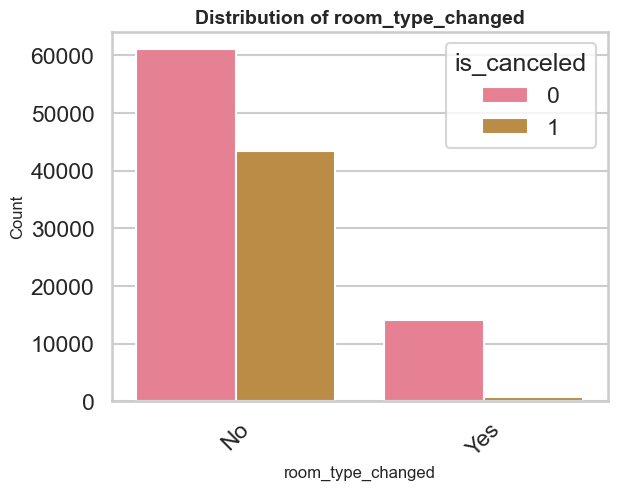

In [27]:
df['room_type_changed'] = df.apply(lambda row: 'No' if row['reserved_room_type'] == row['assigned_room_type'] else 'Yes', axis=1)
plot_categorical_feature(df, 'room_type_changed', ax=plt.gca(), palette=palette, hue='is_canceled')


In [28]:
df.drop(columns=['assigned_room_type'], inplace=True)
#get the categorical columns again
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns

df_cat = df[categorical_columns]

In [29]:
df_cat.head()

,hotel,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,deposit_type,agent,customer_type,room_type_changed
0,Resort Hotel,July,BB,PRT,Direct,Direct,C,No Deposit,No Agent,Transient,No
1,Resort Hotel,July,BB,PRT,Direct,Direct,C,No Deposit,No Agent,Transient,No
2,Resort Hotel,July,BB,GBR,Direct,Direct,A,No Deposit,No Agent,Transient,Yes
3,Resort Hotel,July,BB,GBR,Corporate,Corporate,A,No Deposit,304.0,Transient,No
4,Resort Hotel,July,BB,GBR,Online TA,TA/TO,A,No Deposit,240.0,Transient,No


In [30]:
top_10_countries = df['country'].value_counts().nlargest(10).index
top_10_agents = df['agent'].value_counts().nlargest(10).index
# Group less frequent categories into 'Other' for the 'country' column
df['country'] = df['country'].apply(lambda x: x if x in top_10_countries else 'Other')

# Group less frequent categories into 'Other' for the 'agent' column
df['agent'] = df['agent'].apply(lambda x: x if x in top_10_agents else 'Other')

df_cat = df[categorical_columns]

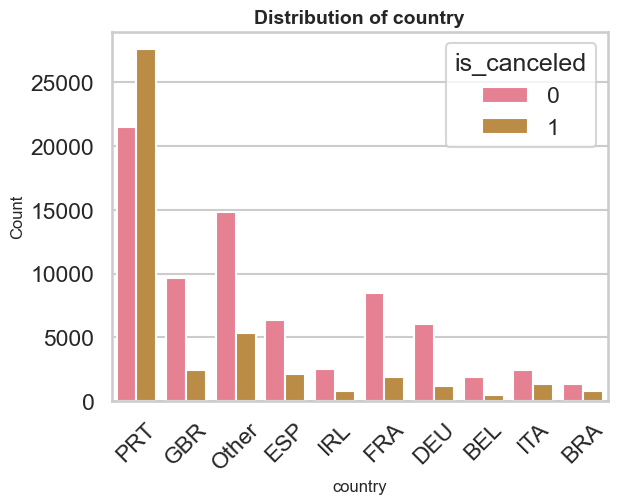

In [31]:
plot_categorical_feature(df, 'country', ax=plt.gca(), palette=palette, hue='is_canceled')

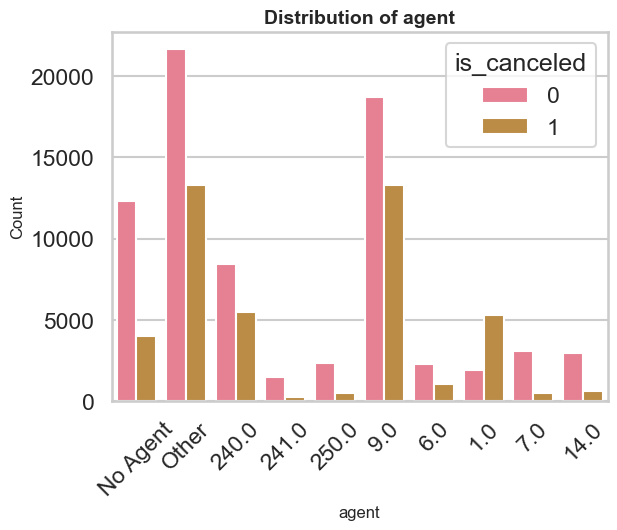

In [32]:
plot_categorical_feature(df, 'agent', ax=plt.gca(), palette=palette, hue='is_canceled')

In [33]:
df['arrival_date_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month
df['arrival_date_month_sin'] = np.sin(2 * np.pi * df['arrival_date_month'] / 12.0)
df['arrival_date_month_cos'] = np.cos(2 * np.pi * df['arrival_date_month'] / 12.0)

df.drop(columns=['arrival_date_month'], inplace=True)

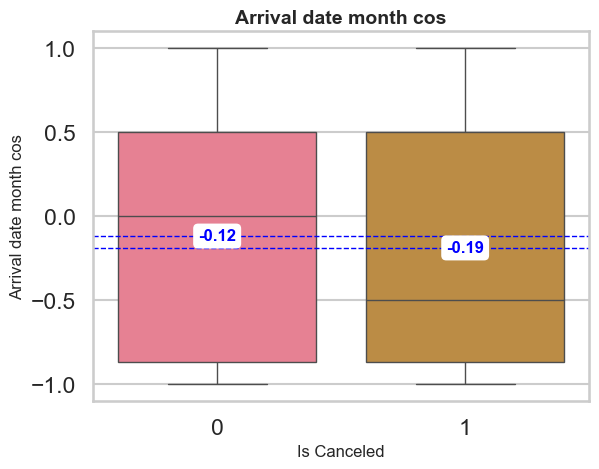

In [34]:
plot_feature_distribution(df, 'arrival_date_month_cos', ax=plt.gca(), palette=palette)

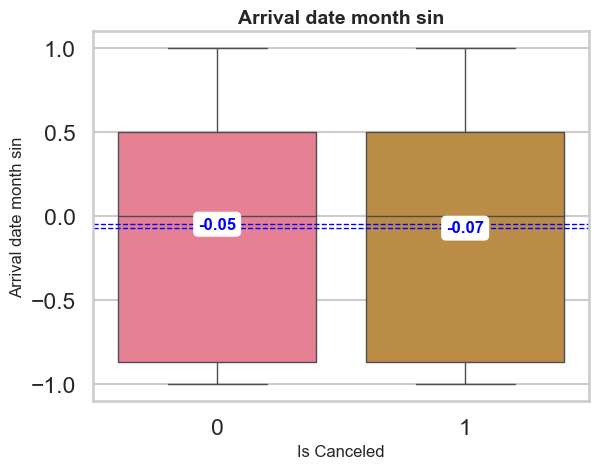

In [35]:
plot_feature_distribution(df, 'arrival_date_month_sin', ax=plt.gca(), palette=palette)

## Feature Encoding

### Label Encoding:
Suitable for binary or ordinal features.

### One-Hot Encoding:
Suitable for nominal features.

In [36]:
categorical_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df_cat = df[categorical_columns]
df_num = df[numerical_columns]
#
df[categorical_columns].nunique()

hotel                    2
meal                     5
country                 11
market_segment           8
distribution_channel     5
reserved_room_type      10
deposit_type             3
agent                   11
customer_type            4
room_type_changed        2
dtype: int64

### Label Encoding:
Features: hotel (2 unique values), room_type_changed (2 unique values)

### One-Hot Encoding:
Features: deposit_type (3 unique values), customer_type (4 unique values), meal (5 unique values), distribution_channel (5 unique values), market_segment (8 unique values), reserved_room_type (10 unique values), country (11 unique values), agent (11 unique values).

In [37]:
df_encoded = df.copy()

df_encoded['hotel'] = LabelEncoder().fit_transform(df_encoded['hotel'])
df_encoded['room_type_changed'] = LabelEncoder().fit_transform(df_encoded['room_type_changed'])
df_encoded.head()


,hotel,is_canceled,lead_time,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,guests,has_children,total_stay_nights,room_type_changed,arrival_date_month_sin,arrival_date_month_cos
0,1,0,1.240939,BB,PRT,Direct,Direct,0,-0.211884,-0.152928,...,Transient,-6.089709,0,0,2.0,0,-2.829076,0,-0.5,-0.866025
1,1,0,1.716912,BB,PRT,Direct,Direct,0,-0.211884,-0.152928,...,Transient,-6.089709,0,0,2.0,0,-2.829076,0,-0.5,-0.866025
2,1,0,-1.093718,BB,GBR,Direct,Direct,0,-0.211884,-0.152928,...,Transient,-0.198225,0,0,1.0,0,-1.391766,1,-0.5,-0.866025
3,1,0,-0.746084,BB,GBR,Corporate,Corporate,0,-0.211884,-0.152928,...,Transient,-0.198225,0,0,1.0,0,-1.391766,0,-0.5,-0.866025
4,1,0,-0.703225,BB,GBR,Online TA,TA/TO,0,-0.211884,-0.152928,...,Transient,0.161443,0,1,2.0,0,-0.550994,0,-0.5,-0.866025


In [38]:
# Appl One-Hot Encoding to the remaining categorical features
categorical_columns = df_encoded.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df_encoded, columns=categorical_columns, drop_first=True)

df_encoded.head()

,hotel,is_canceled,lead_time,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,...,agent_14.0,agent_28.0,agent_240.0,agent_241.0,agent_250.0,agent_No Agent,agent_Other,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,0,1.240939,0,-0.211884,-0.152928,3,-0.174769,-6.089709,0,...,0,0,0,0,0,1,0,0,1,0
1,1,0,1.716912,0,-0.211884,-0.152928,4,-0.174769,-6.089709,0,...,0,0,0,0,0,1,0,0,1,0
2,1,0,-1.093718,0,-0.211884,-0.152928,0,-0.174769,-0.198225,0,...,0,0,0,0,0,1,0,0,1,0
3,1,0,-0.746084,0,-0.211884,-0.152928,0,-0.174769,-0.198225,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,-0.703225,0,-0.211884,-0.152928,0,-0.174769,0.161443,0,...,0,0,1,0,0,0,0,0,1,0


## Model Training & Evaluation

### Define some common methods

In [39]:
def split_data(df, target, size=0.2):
    df_copy = df.copy()
    X = df_copy.drop(columns=[target])
    y = df_copy[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    return X_train, X_test, y_train, y_test

# Map of models to train
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def run_model(X_train, X_test, y_train, y_test, model_name):
    model_instance = models[model_name]
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f'Model: {model_name}')
    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(cm, title=f'Confusion Matrix for {model_name}')
    return y_pred


### Split the data

In [40]:
X_train, X_test, y_train, y_test = split_data(df_encoded, target='is_canceled')

### 1. Logistic Regression

Model: Logistic Regression
Accuracy: 0.8391
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     14907
           1       0.82      0.73      0.77      8971

    accuracy                           0.84     23878
   macro avg       0.84      0.82      0.82     23878
weighted avg       0.84      0.84      0.84     23878



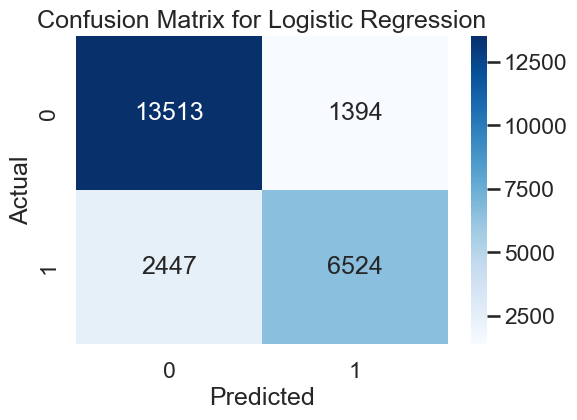

In [41]:
y_logreg = run_model(X_train, X_test, y_train, y_test, model_name='Logistic Regression')

### 2. Random Forest

Model: Random Forest
Accuracy: 0.8950
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14907
           1       0.88      0.83      0.86      8971

    accuracy                           0.89     23878
   macro avg       0.89      0.88      0.89     23878
weighted avg       0.89      0.89      0.89     23878



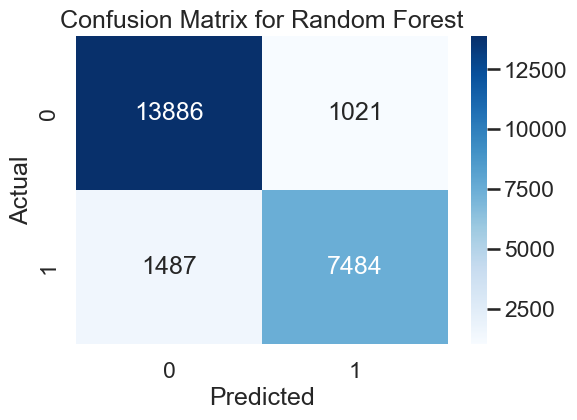

In [42]:
y_rf = run_model(X_train, X_test, y_train, y_test, model_name='Random Forest')

### 3. Gradient Boosting

Model: Gradient Boosting
Accuracy: 0.8576
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     14907
           1       0.85      0.76      0.80      8971

    accuracy                           0.86     23878
   macro avg       0.86      0.84      0.84     23878
weighted avg       0.86      0.86      0.86     23878



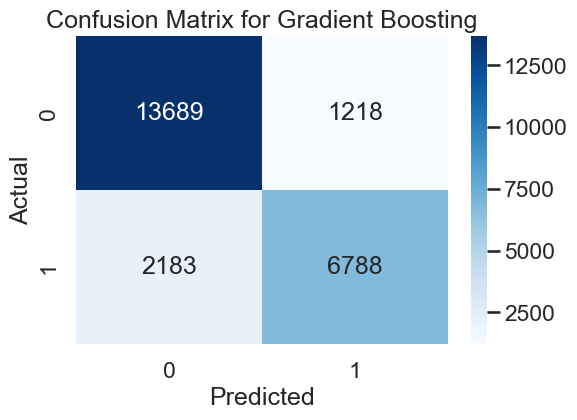

In [43]:
y_gb = run_model(X_train, X_test, y_train, y_test, model_name='Gradient Boosting')

### 4. Decision Tree

Model: Decision Tree
Accuracy: 0.8584
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     14907
           1       0.81      0.81      0.81      8971

    accuracy                           0.86     23878
   macro avg       0.85      0.85      0.85     23878
weighted avg       0.86      0.86      0.86     23878



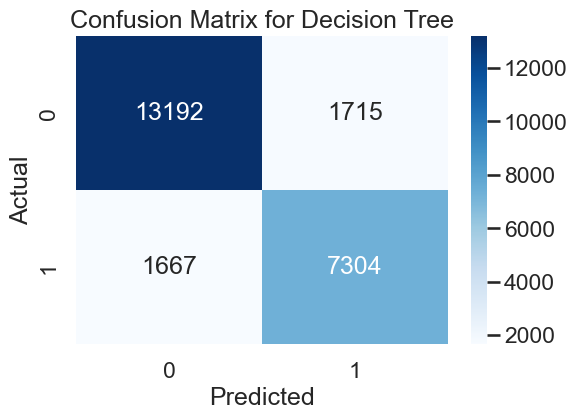

In [44]:
y_dt = run_model(X_train, X_test, y_train, y_test, model_name='Decision Tree')

### 5. K-Nearest Neighbors

Model: K-Nearest Neighbors
Accuracy: 0.8600
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     14907
           1       0.82      0.81      0.81      8971

    accuracy                           0.86     23878
   macro avg       0.85      0.85      0.85     23878
weighted avg       0.86      0.86      0.86     23878



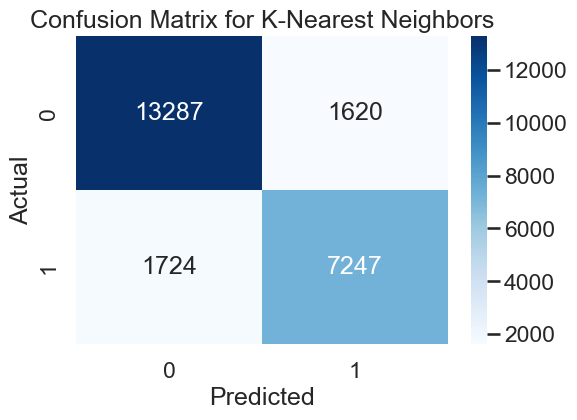

In [45]:
y_kn = run_model(X_train, X_test, y_train, y_test, model_name='K-Nearest Neighbors')

### 6. Naive Bayes

Model: Naive Bayes
Accuracy: 0.7886
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84     14907
           1       0.77      0.62      0.69      8971

    accuracy                           0.79     23878
   macro avg       0.78      0.75      0.76     23878
weighted avg       0.79      0.79      0.78     23878



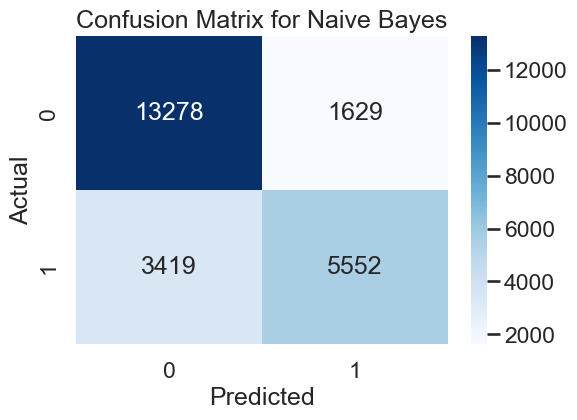

In [46]:
y_nb = run_model(X_train, X_test, y_train, y_test, model_name='Naive Bayes')

### 7. AdaBoost

Model: AdaBoost
Accuracy: 0.8378
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.88     14907
           1       0.83      0.71      0.77      8971

    accuracy                           0.84     23878
   macro avg       0.84      0.81      0.82     23878
weighted avg       0.84      0.84      0.83     23878



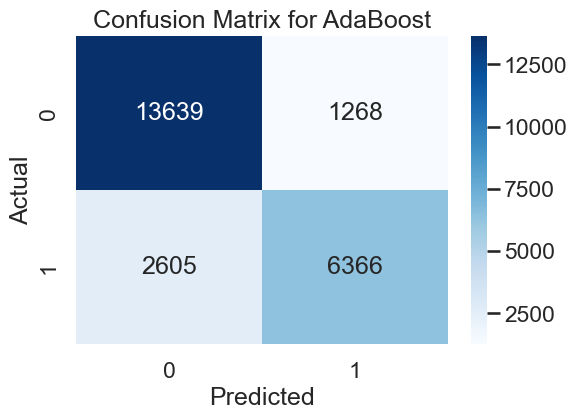

In [47]:
y_ada = run_model(X_train, X_test, y_train, y_test, model_name='AdaBoost')

### 8. XGBoost

Model: XGBoost
Accuracy: 0.8797
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91     14907
           1       0.86      0.81      0.84      8971

    accuracy                           0.88     23878
   macro avg       0.88      0.87      0.87     23878
weighted avg       0.88      0.88      0.88     23878



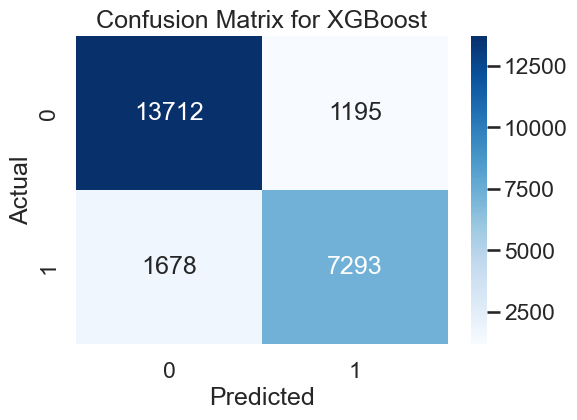

In [48]:
y_xg = run_model(X_train, X_test, y_train, y_test, model_name='XGBoost')

### Final Stats

In [49]:
def get_stats_df(y_logreg, y_rf, y_gb, y_dt, y_kn, y_nb, y_ada, y_xg):
    df_preds = pd.DataFrame({
        'Logistic Regression': y_logreg,
        'Random Forest': y_rf,
        'Gradient Boosting': y_gb,
        'Decision Tree': y_dt,
        'K-Nearest Neighbors': y_kn,
        'Naive Bayes': y_nb,
        'AdaBoost': y_ada,
        'XGBoost': y_xg
    })
    # Calculate all the statistics (accuracy, precision, recall, f1-score) for each model
    model_stats = {}
    for model_name in df_preds.columns:
        accuracy = accuracy_score(y_test, df_preds[model_name])
        classification_rep = classification_report(y_test, df_preds[model_name], output_dict=True)
        model_stats[model_name] = {
            'accuracy': accuracy,
            'precision': classification_rep['weighted avg']['precision'],
            'recall': classification_rep['weighted avg']['recall'],
            'f1-score': classification_rep['weighted avg']['f1-score']
        }
    df_model_stats = pd.DataFrame(model_stats).T
    df_model_stats = df_model_stats.sort_values(by='accuracy', ascending=False)
    return df_model_stats


get_stats_df(y_logreg, y_rf, y_gb, y_dt, y_kn, y_nb, y_ada, y_xg)

,accuracy,precision,recall,f1-score
Random Forest,0.894966,0.894511,0.894966,0.894374
XGBoost,0.879680,0.879038,0.879680,0.878975
K-Nearest Neighbors,0.859955,0.859659,0.859955,0.859790
Decision Tree,0.858363,0.858520,0.858363,0.858438
Gradient Boosting,0.857568,0.856978,0.857568,0.855752
Logistic Regression,0.839141,0.838138,0.839141,0.836870
AdaBoost,0.837800,0.837480,0.837800,0.834751
Naive Bayes,0.788592,0.786937,0.788592,0.782865


### Conclusion: **89.5%** with Random Forest is the best!

## Extra stuff

### SMOTE (Oversampling)
Since our target was unbalanced, I will try to improve the model with SMOTE

In [50]:
#SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
y_train.value_counts(), y_train_resampled.value_counts()

(0    60259
 1    35253
 Name: is_canceled, dtype: int64,
 1    60259
 0    60259
 Name: is_canceled, dtype: int64)

Model: Random Forest
Accuracy: 0.8948
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     14907
           1       0.86      0.86      0.86      8971

    accuracy                           0.89     23878
   macro avg       0.89      0.89      0.89     23878
weighted avg       0.89      0.89      0.89     23878



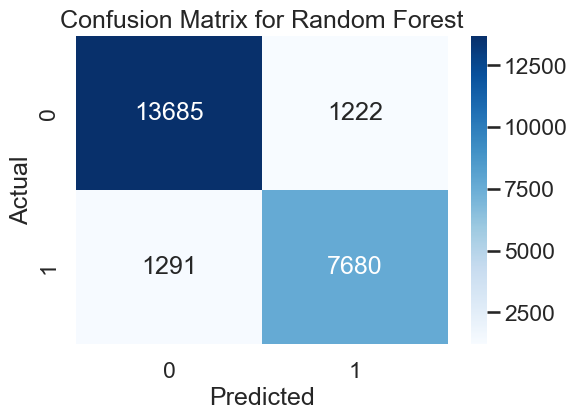

In [51]:
y_rf_resampled = run_model(X_train_resampled, X_test, y_train_resampled, y_test, model_name='Random Forest')

#### Conclusion: the accuracy is slightly lower than before.

### Undersampling

In [52]:
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Check the class distribution after resampling
y_train.value_counts(), y_train_undersampled.value_counts()

(0    60259
 1    35253
 Name: is_canceled, dtype: int64,
 0    35253
 1    35253
 Name: is_canceled, dtype: int64)

Model: Random Forest
Accuracy: 0.8858
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.88      0.91     14907
           1       0.82      0.89      0.85      8971

    accuracy                           0.89     23878
   macro avg       0.88      0.89      0.88     23878
weighted avg       0.89      0.89      0.89     23878



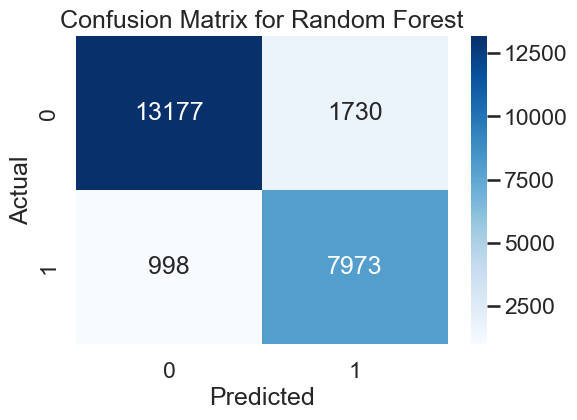

In [53]:
y_rf_undersampled = run_model(X_train_undersampled, X_test, y_train_undersampled, y_test, model_name='Random Forest')

#### Conclusion: the accuracy is 1% lower than before.


### GridSearch for Hyperparameter optimization

In [54]:
# Define the objective function for Optuna
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [10, 20, 30])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

# Create an Optuna study with SuccessiveHalvingPruner and a limit on the number of trials
study = optuna.create_study(direction='maximize', pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=50, n_jobs=-1)

# Get the best hyperparameters
best_params = study.best_params
print("Best parameters found: ", best_params)

# Use the best parameters to fit the model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_rf_best = best_rf.predict(X_test)
accuracy_rf_best = accuracy_score(y_test, y_rf_best)
classification_rep_rf_best = classification_report(y_test, y_rf_best)
print('Accuracy for Random Forest (Best Parameters):', accuracy_rf_best)
print('Classification Report for Random Forest (Best Parameters):')
print(classification_rep_rf_best)

[I 2024-07-18 18:03:52,617] A new study created in memory with name: no-name-d9e4ec77-423a-4315-a373-3e5d515c81db
[I 2024-07-18 18:04:14,895] Trial 4 finished with value: 0.8452655296464613 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 4 with value: 0.8452655296464613.
[I 2024-07-18 18:04:19,974] Trial 5 finished with value: 0.8516207837105094 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.8516207837105094.
[I 2024-07-18 18:04:27,403] Trial 6 finished with value: 0.8753769426542991 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 6 with value: 0.8753769426542991.
[I 2024-07-18 18:04:38,004] Trial 0 finished with value: 0.8448781614163969 and parameters: {'n_estimators': 200, 'max_depth': 10, 'm

Best parameters found:  {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Accuracy for Random Forest (Best Parameters): 0.8959711868665717
Classification Report for Random Forest (Best Parameters):
              precision    recall  f1-score   support

           0       0.90      0.93      0.92     14907
           1       0.88      0.83      0.86      8971

    accuracy                           0.90     23878
   macro avg       0.89      0.88      0.89     23878
weighted avg       0.90      0.90      0.90     23878



#### There was actually a small increase.

Best parameters found:
**{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}**


### Finding the best sample size

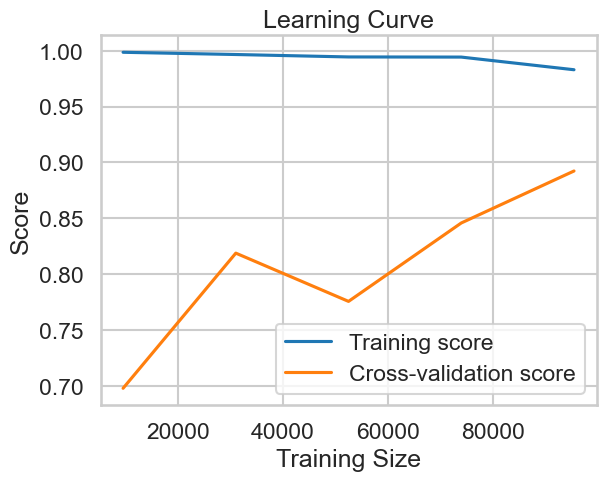

{'split_results': {0.1: {'train_score': 0.9816195289015458,
   'test_score': 0.8953848731049502,
   'X_train_shape': (107451, 65),
   'X_test_shape': (11939, 65),
   'y_train_shape': (107451,),
   'y_test_shape': (11939,)},
  0.2: {'train_score': 0.9841171789932155,
   'test_score': 0.8917832314264176,
   'X_train_shape': (95512, 65),
   'X_test_shape': (23878, 65),
   'y_train_shape': (95512,),
   'y_test_shape': (23878,)},
  0.3: {'train_score': 0.9845284960453735,
   'test_score': 0.8899126113298155,
   'X_train_shape': (83573, 65),
   'X_test_shape': (35817, 65),
   'y_train_shape': (83573,),
   'y_test_shape': (35817,)},
  0.4: {'train_score': 0.9864170645224335,
   'test_score': 0.8876790350950666,
   'X_train_shape': (71634, 65),
   'X_test_shape': (47756, 65),
   'y_train_shape': (71634,),
   'y_test_shape': (47756,)},
  0.5: {'train_score': 0.9885920093810202,
   'test_score': 0.883859619733646,
   'X_train_shape': (59695, 65),
   'X_test_shape': (59695, 65),
   'y_train_shape

In [56]:
def evaluate_sample_sizes(df, target_column, hyperparameters):
    results = {}
    features = df.drop(target_column, axis=1)
    target = df[target_column]

    # Different train-test split ratios to evaluate
    split_ratios = [0.1, 0.2, 0.3, 0.4, 0.5]
    split_results = {}

    for test_size in split_ratios:
        X_train, X_test, y_train, y_test = train_test_split(
            features, target, test_size=test_size, stratify=target, random_state=42)

        model = RandomForestClassifier(**hyperparameters, random_state=42)
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        split_results[test_size] = {
            'train_score': train_score,
            'test_score': test_score,
            'X_train_shape': X_train.shape,
            'X_test_shape': X_test.shape,
            'y_train_shape': y_train.shape,
            'y_test_shape': y_test.shape,
        }

    results['split_results'] = split_results

    # Learning Curve
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, test_scores = learning_curve(
        RandomForestClassifier(**hyperparameters, random_state=42),
        features, target, cv=skf, random_state=42)

    plt.figure()
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Learning Curve')
    plt.show()

    results['learning_curve'] = {
        'train_sizes': train_sizes,
        'train_scores': train_scores.mean(axis=1),
        'test_scores': test_scores.mean(axis=1),
    }

    return results

# Example usage
hyperparameters = {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
results = evaluate_sample_sizes(df_encoded, target_column='is_canceled', hyperparameters=hyperparameters)
results

### Analysis of the Results

#### Learning Curve:
1. **Training Scores**:
   - Training scores are consistently high across different training sizes, indicating the model fits the training data well.
   - Slightly lower training score at the highest training size (0.983) compared to smaller sizes, which might indicate a very slight overfitting at smaller sizes.

2. **Cross-Validation Scores**:
   - Cross-validation scores increase with the training size, indicating the model benefits from more data and generalizes better with larger training sizes.
   - The cross-validation score stabilizes around the highest training size with a score of 0.892.

### Final insights:

#### Preferred Train-Test Split:
- Given that the test score for a 10% test size (0.895) is slightly higher than the 20% test size (0.891), it suggests that the model might perform slightly better with a smaller test size.
- However, the difference is not substantial, so the 20% test size is still a valid choice considering it provides a balance between training data availability and test set size for validation.

#### Learning Curve Insights:
- The learning curve indicates that the model benefits from more data. The cross-validation score improves significantly with more training data.
- Since the performance stabilizes at the largest training size, continuing to use a large training set is beneficial.

In [63]:
X_train, X_test, y_train, y_test = split_data(df_encoded, target='is_canceled', size=0.1)
best_rf = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200)
best_rf.fit(X_train, y_train)
y_rf_best = best_rf.predict(X_test)
accuracy_rf_best = accuracy_score(y_test, y_rf_best)
classification_rep_rf_best = classification_report(y_test, y_rf_best)
print('Best Accuracy for Random Forest (Best Parameters):', accuracy_rf_best)
print('Best Classification Report for Random Forest (Best Parameters):')
print(classification_rep_rf_best)

Best Accuracy for Random Forest (Best Parameters): 0.8995728285451042
Best Classification Report for Random Forest (Best Parameters):
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7428
           1       0.88      0.85      0.86      4511

    accuracy                           0.90     11939
   macro avg       0.90      0.89      0.89     11939
weighted avg       0.90      0.90      0.90     11939



### Feature Importance

In [58]:
# Get feature importances
feature_importances = best_rf.feature_importances_
feature_importances = pd.Series(feature_importances, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
for i, (feature, importance) in enumerate(feature_importances.items()):
    print(f'{i + 1}. {feature}: {importance:.4f}')

1. lead_time: 0.1417
2. deposit_type_Non Refund: 0.1031
3. country_PRT: 0.0865
4. adr: 0.0848
5. total_of_special_requests: 0.0665
6. total_stay_nights: 0.0499
7. room_type_changed: 0.0378
8. previous_cancellations: 0.0333
9. arrival_date_month_sin: 0.0325
10. arrival_date_month_cos: 0.0310
11. required_car_parking_spaces: 0.0259
12. booking_changes: 0.0240
13. agent_9.0: 0.0212
14. customer_type_Transient: 0.0202
15. market_segment_Online TA: 0.0189
16. guests: 0.0176
17. market_segment_Groups: 0.0172
18. agent_Other: 0.0158
19. customer_type_Transient-Party: 0.0133
20. distribution_channel_TA/TO: 0.0108
21. market_segment_Offline TA/TO: 0.0097
22. hotel: 0.0095
23. agent_240.0: 0.0094
24. reserved_room_type_D: 0.0078
25. meal_HB: 0.0073
26. country_Other: 0.0073
27. country_GBR: 0.0067
28. market_segment_Direct: 0.0062
29. country_FRA: 0.0057
30. agent_7.0: 0.0055
31. country_DEU: 0.0053
32. previous_bookings_not_canceled: 0.0051
33. meal_SC: 0.0050
34. distribution_channel_Direct: 0

In [59]:
# try to remove features with importance below this value and check the accuracy for each case. Some threshold values do not make sense, but we will check them anyway

thresholds = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0]
for threshold in thresholds:
    # Select the features with importance above the threshold
    selected_features = feature_importances[feature_importances > threshold].index
    # Filter the training and testing datasets
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]
    # Fit the model
    best_rf.fit(X_train_selected, y_train)
    # Predict the target variable
    y_rf_best = best_rf.predict(X_test_selected)
    # Calculate the accuracy
    accuracy_rf_best = accuracy_score(y_test, y_rf_best)
    print(f'Threshold: {threshold}, Accuracy: {accuracy_rf_best:.4f}')

Threshold: 0.1, Accuracy: 0.7542
Threshold: 0.05, Accuracy: 0.8244
Threshold: 0.01, Accuracy: 0.8911
Threshold: 0.005, Accuracy: 0.8968
Threshold: 0.001, Accuracy: 0.8978
Threshold: 0.0005, Accuracy: 0.8981
Threshold: 0.0001, Accuracy: 0.8983
Threshold: 0, Accuracy: 0.8984


### Impact of Removing Low-Importance Columns

Removing columns with low importance does not significantly impact model performance. The accuracy remains close to 90%, which is the best result achieved so far.


### Deep Learning

Epoch 1/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 3s 716us/step - accuracy: 0.8045 - loss: 0.4062 - val_accuracy: 0.8612 - val_loss: 0.2992
Epoch 2/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 679us/step - accuracy: 0.8552 - loss: 0.3126 - val_accuracy: 0.8644 - val_loss: 0.2929
Epoch 3/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 673us/step - accuracy: 0.8584 - loss: 0.3064 - val_accuracy: 0.8656 - val_loss: 0.2877
Epoch 4/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 673us/step - accuracy: 0.8602 - loss: 0.3005 - val_accuracy: 0.8670 - val_loss: 0.2850
Epoch 5/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 653us/step - accuracy: 0.8635 - loss: 0.2967 - val_accuracy: 0.8667 - val_loss: 0.2848
Epoch 6/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - accuracy: 0.8641 - loss: 0.2940 - val_accuracy: 0.8676 - val_loss: 0.2798
Epoch 7/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 666us/step - accuracy: 0.8639 - loss: 0.2943 - val_accuracy: 0.8684 - val_loss: 0.2797
Epoch 8/100
3358/3358 ━━━━━━━━━━━━━━━━━━━━ 2s 686us/step - accuracy: 

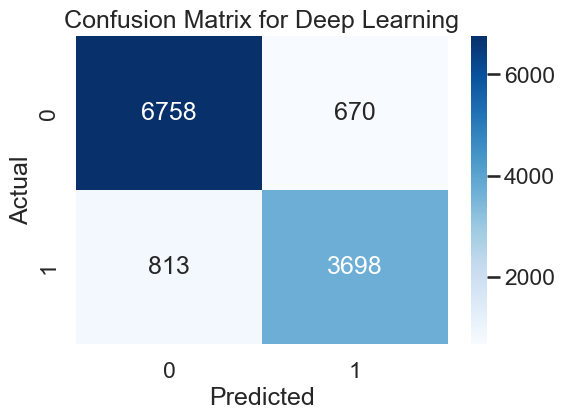

In [60]:
# Convert the target variable to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Initialize the model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Initialize the Early Stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test_cat)
print('Accuracy for Deep Learning:', accuracy)
y_dl = model.predict(X_test)
print('Classification Report for Deep Learning:')
print(classification_report(y_test, y_dl.argmax(axis=1)))
print('Confusion Matrix for Deep Learning:')
plot_confusion_matrix(confusion_matrix(y_test, y_dl.argmax(axis=1)), title='Confusion Matrix for Deep Learning')

#### Worse than random forest!

### Deep Learning Hyperparameter Optimization

Reloading Tuner from keras_tuner/hotel_bookings/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first layer is 224,
the optimal number of additional layers is 2.

The optimal number of units in layer 2 is 224, with a dropout rate of 0.30000000000000004.
The optimal number of units in layer 3 is 160, with a dropout rate of 0.2.
The optimal learning rate is 0.001.
Epoch 1/20
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8150 - loss: 0.3975 - val_accuracy: 0.8650 - val_loss: 0.2926
Epoch 2/20
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8506 - loss: 0.3162 - val_accuracy: 0.8679 - val_loss: 0.2860
Epoch 3/20
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8577 - loss: 0.3034 - val_accuracy: 0.8667 - val_loss: 0.2857
Epoch 4/20
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8611 - loss: 0.2982 - val_accuracy: 0.8687 - val_loss: 0.2793
Epoch 5/20
1679/1679 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8638 - l

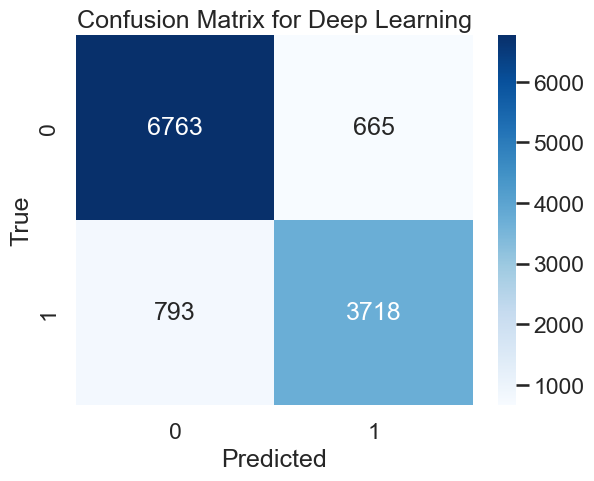

In [62]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=32, max_value=256, step=32),
                    input_shape=(X_train.shape[1],), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i+2}', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])),
                  loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Initialize the Keras Tuner
tuner = kt.RandomSearch(build_model, objective='val_accuracy', max_trials=20, executions_per_trial=2,
                        directory='keras_tuner', project_name='hotel_bookings')

# Early Stopping Callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
             epochs=20, batch_size=64, callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first layer is {best_hps.get('units1')},
the optimal number of additional layers is {best_hps.get('num_layers')}.
""")
for i in range(best_hps.get('num_layers')):
    print(f"The optimal number of units in layer {i+2} is {best_hps.get(f'units_{i+2}')}, with a dropout rate of {best_hps.get(f'dropout_{i+2}')}.")
print(f"The optimal learning rate is {best_hps.get('learning_rate')}.")

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                    epochs=20, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
_, accuracy = model.evaluate(X_test, y_test_cat)
print('Accuracy for Deep Learning:', accuracy)

# Predict and evaluate
y_dl = model.predict(X_test)
print('Classification Report for Deep Learning:')
print(classification_report(y_test, y_dl.argmax(axis=1)))
print('Confusion Matrix for Deep Learning:')
cm = confusion_matrix(y_test, y_dl.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Deep Learning')
plt.show()

### It didn't increase by much as expected!

# Top 3 Results

## Random Forest: 89.9% accuracy
## XGBoost (non optimised): 87.9% accuracy
## Deep Learning: 87.8% accuracy